In [21]:
import pandas as pd

a = pd.read_csv('cWGANGP_0_100_epochs.csv')
b = pd.read_csv('cWGANGP_100_500_epochs.csv')
c = pd.read_csv('cWGANGP_986_1000_epochs.csv')
d = pd.read_csv('cWGANGP_1220_1500_epochs.csv')
f = pd.read_csv('cWGANGP_1500_1600_epochs.csv')
# g = pd.read_csv('cWGANGP_1600_2501_epochs.csv')


# e = pd.concat([a,b,c,d, f, g]).reset_index(drop = True)
e = pd.concat([a,b,c,d, f])#.reset_index(drop = True)

# e = e.loc[range(1500)]

In [26]:
aa = pd.concat([a,b]).reset_index(drop= True)

In [10]:
import matplotlib.pyplot as plt

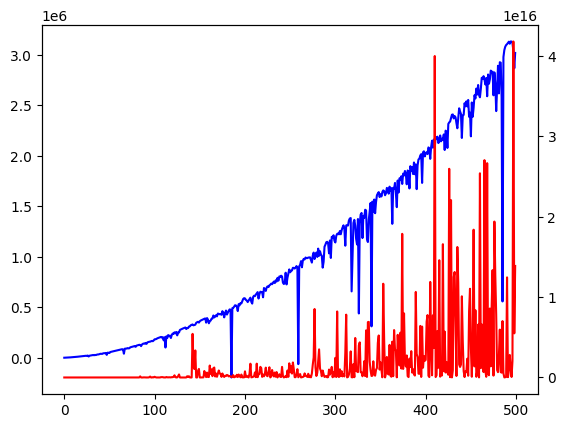

In [29]:
fig, axes = plt.subplots(1,1)

ax1 = plt.subplot(1,1,1)
plt.plot(range(500), aa['Gen_Loss'], color = 'blue')

ax1a = ax1.twinx()
plt.plot(range(500), aa['Dis_Loss'], color = 'red')

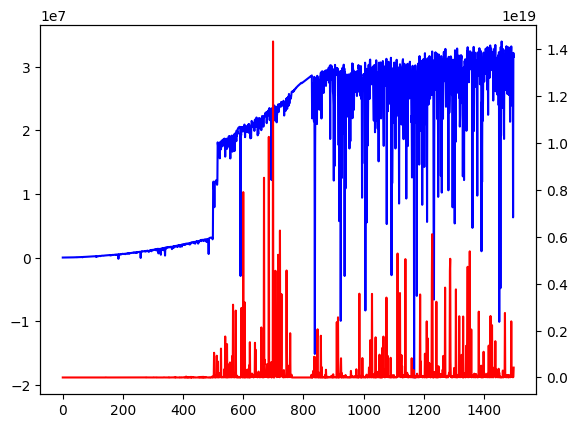

In [16]:
fig, axes = plt.subplots(1,1)

ax1 = plt.subplot(1,1,1)
plt.plot(range(1500), e['Gen_Loss'], color = 'blue')

ax1a = ax1.twinx()
plt.plot(range(1500), e['Dis_Loss'], color = 'red')

In [ ]:
e.to_csv('cWGANGP_History_Complete.csv', index = True)

In [1]:
# !tar -czf generated_cWGAN_GP.tar.gz generated_cWGAN_GP

In [2]:
# !pip install gdown --quiet
# !pip install tqdm --quiet
# import gdown
# !gdown '1ZVyjPmNVA_kAyEmHvamEkLyExHQez73O'
# !unzip 'COVID-19_Radiography_Dataset_Balanced.zip' -d ""

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import multiprocessing
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

%matplotlib inline

In [4]:
!nvidia-smi

Sat Nov 26 10:37:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   20C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Getting the data

In [5]:
import os

DATA_DIR = r"COVID-19_Radiography_Dataset_Balanced"
print(os.listdir(DATA_DIR))

['Viral Pneumonia', 'COVID']


# WGAN-GP

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
CHANNELS_IMG = 1
stats = [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize(image_size),
    # T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
n_classes  = len(train_ds.classes)

In [10]:
len(train_ds)

4962

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

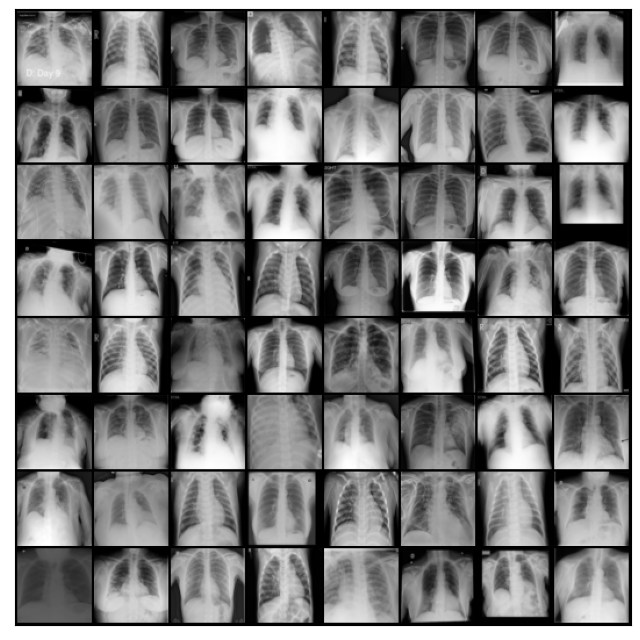

In [14]:
show_batch(train_dl)

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
CRITIC_ITERATIONS = 5
# WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

In [19]:
import torch.nn as nn

# Creating generator and discriminator models

In [20]:
latent_size = 100

In [21]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [22]:
image_shape = train_ds[0][0].shape

generator_input_dim, discriminator_im_chan = get_input_dimensions(latent_size, image_shape, n_classes)
print('Genertor input dim: ', generator_input_dim)
print('Discriminator input channel: ', discriminator_im_chan)

Genertor input dim:  102
Discriminator input channel:  3


<b> Discriminator architecture

In [23]:
# ''' FOR 256 * 256 Image Generation '''
# discriminator = nn.Sequential(
    
#     # in: discriminator_im_chan x 256 x 256
#     nn.Conv2d(discriminator_im_chan, 8, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(8),
#     nn.LeakyReLU(0.2, inplace=True),
    
#     # in:  x 128 x 128
#     nn.Conv2d(8, 32, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(32),
#     nn.LeakyReLU(0.2, inplace=True),
#     #-----------------------------------------------------------------
#     # in: 3 x 64 x 64
#     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 64 x 32 x 32

#     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 16 x 16

#     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 8 x 8

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False))
    # out: 1 x 1 x 1

''' FOR 64 * 64 Image Generation '''
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(discriminator_im_chan, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False))

discriminator = to_device(discriminator, device)

<b> Generator architecture

In [24]:
# ''' FOR 256 * 256 Image Generation '''
# generator = nn.Sequential(
#     # in: latent_size x 1 x 1
#     # 128 * 1 * 1 -> done
#     nn.ConvTranspose2d(generator_input_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),

#     # out: 512 x 4 x 4 -> done

#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # out: 256 x 8 x 8

#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # out: 128 x 16 x 16

#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # out: 64 x 32 x 32

#     nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(32),
#     nn.ReLU(True),
#     # out: 32 x 64 x 64

#     nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(16),
#     nn.ReLU(True),
#     # out: 32 x 128 x 128

#     nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
#     # out: 1 x 256 x 256
# )


''' FOR 64 * 64 Image Generation '''
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    # generator_input_dim * 1 * 1 -> done
    nn.ConvTranspose2d(generator_input_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # out: 512 x 4 x 4 -> done

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)
generator = to_device(generator, device)

In [25]:
# xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

# Generator and discriminator training methodology

In [26]:
import torch.nn.functional as F

In [27]:
def train_discriminator(real_images, opt_d, cur_batch_size, real_labels):
    # Clear discriminator gradients
    opt_d.zero_grad()

    ''' Getting fake images from generator for corresponding labels: real_labels'''
    one_hot_labels = F.one_hot(real_labels.to(device), n_classes)
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_size, image_size)

    # generate fake images
    noise = torch.randn(cur_batch_size, latent_size, device=device)
    noise_and_labels = torch.cat([noise, one_hot_labels.float()],dim=1)
    noise_and_labels = noise_and_labels.view(len(noise_and_labels), generator_input_dim, 1, 1)
    fake_images = generator(noise_and_labels)
    # Pass real images through discriminator
    
    

    ''' getting putputs from generator by passing real and fake images correspondingly '''
    fake_image_and_labels = torch.cat([fake_images,image_one_hot_labels],dim=1)
    real_image_and_labels = torch.cat([real_images,image_one_hot_labels],dim=1)

    # passing real images through discriminator
    real_preds = discriminator(real_image_and_labels).reshape(-1)

    # pass fake images through discriminator
    fake_preds = discriminator(fake_image_and_labels).reshape(-1)

    gp = gradient_penalty(real_images,fake_images, image_one_hot_labels,device = device)

    loss = -(torch.mean(real_preds) - torch.mean(fake_preds)) + LAMBDA_GP * gp

    loss.backward()
    opt_d.step()
    return loss.item()

In [28]:
def train_generator(opt_g, cur_batch_size, real_labels):
    # Clear generator gradients
    opt_g.zero_grad()
    
    ''' Getting fake images from generator for corresponding labels: real_labels'''
    one_hot_labels = F.one_hot(real_labels.to(device), n_classes)
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_size, image_size)

    # generate fake images
    noise = torch.randn(cur_batch_size, latent_size, device=device)
    noise_and_labels = torch.cat([noise, one_hot_labels.float()],dim=1)
    noise_and_labels = noise_and_labels.view(len(noise_and_labels), generator_input_dim, 1, 1)
    fake_images = generator(noise_and_labels)


    ''' getting putputs from generator by passing real and fake images correspondingly '''
     # Try to fool the discriminator
    fake_image_and_labels = torch.cat([fake_images,image_one_hot_labels],dim=1)
    preds = discriminator(fake_image_and_labels).reshape(-1)
    
    
    loss = -torch.mean(preds)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [29]:
from torchvision.utils import save_image
sample_dir = 'generated_cWGAN_GP'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, real_labels, show=True):

    first_64_labels = real_labels[:64]
    ''' Getting fake images from generator for corresponding labels: real_labels'''
    one_hot_labels = F.one_hot(first_64_labels.to(device), n_classes)

    # generate fake images
    noise = torch.randn(len(first_64_labels), latent_size, device=device)
    noise_and_labels = torch.cat([noise, one_hot_labels.float()],dim=1)
    noise_and_labels = noise_and_labels.view(len(noise_and_labels), generator_input_dim, 1, 1)
    fake_images = generator(noise_and_labels)

    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

## Traininig Loop

In [30]:
def gradient_penalty(real,fake_images, image_one_hot_labels,device = device):
    BATCH_SIZE, C, W, H = real.shape#[0]
    epsilon = torch.rand((BATCH_SIZE, 1,1,1)).repeat(1, C, H, W)
    epsilon = epsilon.to(device)

    interpolated_images = real * epsilon + fake_images * (1 - epsilon)

    # lets calculate critics score
    fake_image_and_labels_from_interpolated_imgs = torch.cat([interpolated_images,image_one_hot_labels],dim=1)
    mixed_scores = discriminator(fake_image_and_labels_from_interpolated_imgs)

    # Computes and returns the sum of gradients of outputs with respect to the inputs.
    # https://pytorch.org/docs/stable/generated/torch.ones_like.html
    # l2 norm : https://www.analyticsvidhya.com/blog/2021/03/must-known-vector-norms-in-machine-learning/
    gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores)
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim = 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
lr = 0.0002#1e-4

opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.999))

In [33]:
from tqdm import tqdm

In [34]:
generator.load_state_dict(torch.load(r'cWGANGP_generator.pth'))
discriminator.load_state_dict(torch.load(r'cWGANGP_discriminator.pth'))

<All keys matched successfully>

In [35]:
def fit(start, end, lr, opt_d, opt_g, start_idx=1):
    torch.cuda.empty_cache()
    # Losses 
    losses_g = []
    losses_d = []
    
    for epoch in range(start, end):
        for real_images, real_labels in train_dl:
            cur_batch_size = real_images.shape[0]
            # Train discriminator
            for _ in range(CRITIC_ITERATIONS):
                loss_d = train_discriminator(
                    real_images, opt_d, cur_batch_size, real_labels
                )
            # Train generator
            loss_g = train_generator(opt_g, cur_batch_size, real_labels)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)

        # Log losses & scores (last batch)
        print(
            "Epoch [{}/{}]c, loss_g: {:.4f}, loss_d: {:.4f}".format(
                epoch + 1, end, loss_g, loss_d
            )
        )
        
        if epoch % 10 == 0:
            # Save generated images
            save_samples(epoch + start_idx, real_labels, show=False)
            print("\nSaving Generator and discriminator weights in Epoch-> {}\n".format(epoch))
            torch.save(generator.state_dict(), 'cWGANGP_generator.pth')
            torch.save(discriminator.state_dict(), 'cWGANGP_discriminator.pth')
    
    
    name_of_csv_with_error_data = 'cWGANGP_'+str(start)+'_'+str(end) + '_epochs.csv'
    # Saving losses
    pd.DataFrame({
        'Gen_Loss': losses_g,
        'Dis_Loss': losses_d}).to_csv(name_of_csv_with_error_data, index = True)
    

In [38]:
start = 1600
end = 1601

In [ ]:
fit(start, end, lr, opt_d, opt_g)

In [ ]:
# torch.save(generator.state_dict(), '/content/Conditional_WGANGP_256_256.pth')

## Generating New Images

In [ ]:
def get_an_image(class_):
  label = torch.tensor([class_])
  one_hot_labels = F.one_hot(label.to(device), n_classes)

  # generate fake images
  noise = torch.randn(len(label), latent_size, device=device)
  noise_and_labels = torch.cat([noise, one_hot_labels.float()],dim=1)
  noise_and_labels = noise_and_labels.view(len(noise_and_labels), generator_input_dim, 1, 1)
  fake_images = generator(noise_and_labels)[0].detach().to('cpu')
  print(train_ds.classes[class_])
  plt.imshow(denorm(fake_images)[0], cmap='gray')

In [ ]:
get_an_image(0)

RuntimeError: ignored

Normal


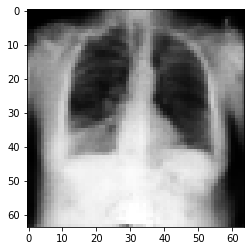

In [ ]:
get_an_image(1)

Viral Pneumonia


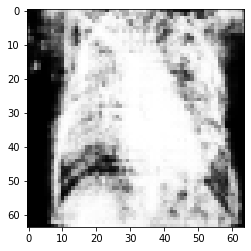

In [ ]:
get_an_image(2)